# 電信客戶流失(Telco Customer Churn)

***
>### 專案介紹：
預測客戶是否在上個月流失(Churn)。電信公司、網路提供商，有線電視公司和保險公司通常使用客戶流失分析和客戶流失率作為其KPI，因為保留現有客戶的成本遠低於獲得新的客戶。這些行業的公司經常設有客戶服務部門，試圖挽留客戶，因為與新招募的客戶相比，恢復的長期客戶對公司的價值更高。公司通常會區分自願流失和非自願流失:由於客戶決定轉換到另一家公司而發生自願流失及由於客戶搬家而發生非自願流失。在大多數應用中，非自願流失被排除在分析模型之外，因為它並非由公司控制的。由於預測模型能夠生成潛在流失的客群，因此可以有效地將客戶保留行銷方案集中在最易流失的客群中。

>### 方法概述：
首先使用探索性資料分析了解各個特徵與流失率的關係，再使用 Scikit-learn 實現 9 種不同算法。其中，由於資料集存在不平衡目標特徵，因此利用生成特徵(SMOTE)加強模型泛化能力與特徵選擇(RFE)嘗試使用較少特徵預測，最後透過學習曲線、混淆矩陣及 ROC 曲線評估模型。

## 目錄
- <a href='#1'>1. 資料探索</a>
- <a href='#2'>2. 資料整理</a>
- <a href='#3'>3. 探索性資料分析</a>
    - <a href='#3.1'>3.1. 目標變數</a>
    - <a href='#3.2'>3.2. 數值變數</a>
    - <a href='#3.3'>3.3. 類別變數</a>
- <a href='#4'>4. 資料前處理</a>
- <a href='#5'>5. 建立模型</a>
    - <a href='#5.1'>5.1. Logistic Regression (Baseline)</a>
    - <a href='#5.2'>5.2. Synthetic Minority Oversampling Technique (SMOTE)</a>
    - <a href='#5.3'>5.3. Recursive Feature Elimination (RFE)</a>
    - <a href='#5.4'>5.4. K-Neighbors Classifier</a>
    - <a href='#5.5'>5.5. Decision Tree Classifier</a>
    - <a href='#5.6'>5.6. RandomForest Classifier</a>
    - <a href='#5.7'>5.7. Gaussian Naive Bayes</a>
    - <a href='#5.8'>5.8. Support Vector Machine</a>
    - <a href='#5.9'>5.9. LGBM Classifier</a>
    - <a href='#5.10'>5.10. XGBoost Classifier</a>
    - <a href='#5.11'>5.11. MLP Classifier</a>
- <a href='#6'>6. 模型評估</a>
    - <a href='#6.1'>6.1. 模型評估表</a>
    - <a href='#6.2'>6.2. 學習曲線評估</a>
    - <a href='#6.3'>6.3. 混淆矩陣評估</a>
    - <a href='#6.4'>6.4. ROC 曲線評估</a>
- <a href='#7'>7. 結論</a>
- <a href='#8'>8. 參考資料</a>

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from time import time
import tools as tl

# <a id='1'>1. 資料探索</a>

In [2]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [3]:
print ("Rows     : " ,data.shape[0])
print ("Columns  : " ,data.shape[1])
print ("\nFeatures : \n" ,data.columns.tolist())
print ("\nMissing values :  ", data.isnull().sum().values.sum())
print ("\nUnique values :  \n",data.nunique())
print ("\nduplicate values :  \n",data.duplicated().sum())

Rows     :  7043
Columns  :  21

Features : 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values :   0

Unique values :  
 customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

duplicate values :  
 0


# <a id='2'>2. 資料整理</a>

In [4]:
#'TotalCharges'空值代表尚未支付任何費用，以0代替
data['TotalCharges'] = data['TotalCharges'].replace(" ", 0).astype('float32')

#replace values
data["SeniorCitizen"] = data["SeniorCitizen"].replace({1:"Yes",0:"No"})

#Separating churn and non churn customers
churn     = data[data["Churn"] == "Yes"]
not_churn = data[data["Churn"] == "No"]

# <a id='3'>3. 探索性資料分析</a>

## <a id='3.1'>3.1. 目標變數</a>

In [5]:
not_churn.customerID.count()/len(data)

0.7346301292063041

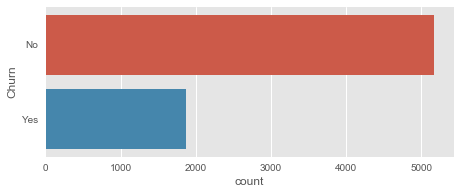

In [6]:
plt.style.use("ggplot")
sns.catplot(y="Churn", kind="count", data=data, height=2.6, aspect=2.5, orient='h')

* 不平衡(unbalanced)的目標變數:
    * 未流失者(Churn==No)佔 73.4%
    * 流失者(Churn==Yes)佔 26.6%

## <a id='3.2'>3.2. 數值變數</a>
三個數值變數分別為往來時間(tenure)、每月收取金額(MonthlyCharges)及總收取金額(TotalCharges)

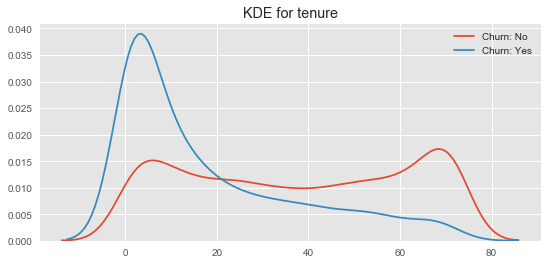

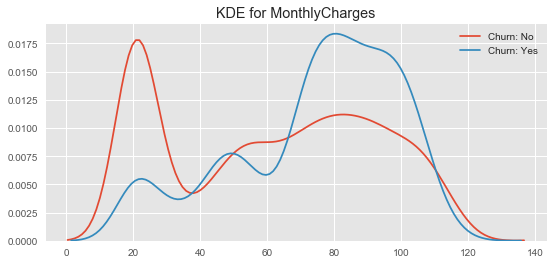

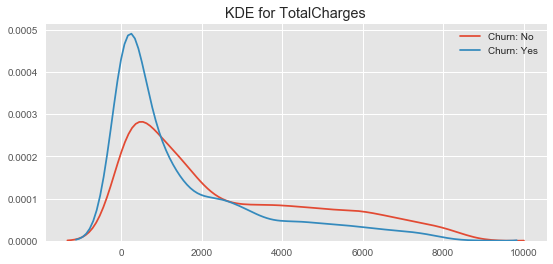

In [7]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(data[data['Churn'] == 'No'][feature], label= 'Churn: No')
    ax1 = sns.kdeplot(data[data['Churn'] == 'Yes'][feature], label= 'Churn: Yes')
kdeplot('tenure')
kdeplot('MonthlyCharges')
kdeplot('TotalCharges')

* 往來時間(tenure)越少的客戶更容易流失。
* 每月收取金額(MonthlyCharges)越高的客戶更容易流失。 

## <a id='3.3'>3.3. 類別變數</a>
其中包含 6 個二元變數、 9 個三元變數、 1 個四元變數

In [8]:
data['Churn_n'] = data['Churn'].map({"Yes":1,"No":0})

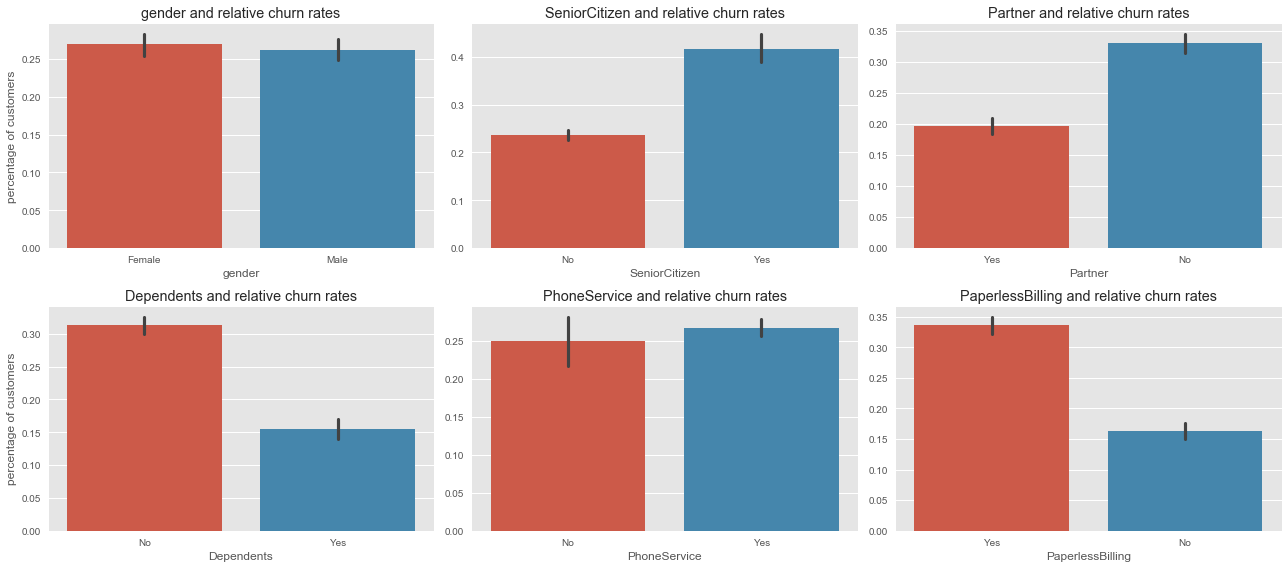

In [9]:
bi_fearures = [x for x in data.columns[data.nunique()==2] if x not in ('Churn','Churn_n')]
fig, axis = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 8))
for n,i in enumerate(bi_fearures):
    if n <3 :
        p = 0
    else :
        p = 1
        n-=3
    ax = sns.barplot(data[i],data['Churn_n'],ax=axis[p][n])
    if ((p == 0) & (n == 0))|((p == 1) & (n == 0)) :
        ax.set_ylabel('percentage of customers')
    else:
        ax.set_ylabel('')
    ax.set_title("{} and relative churn rates".format(i))
    plt.tight_layout()

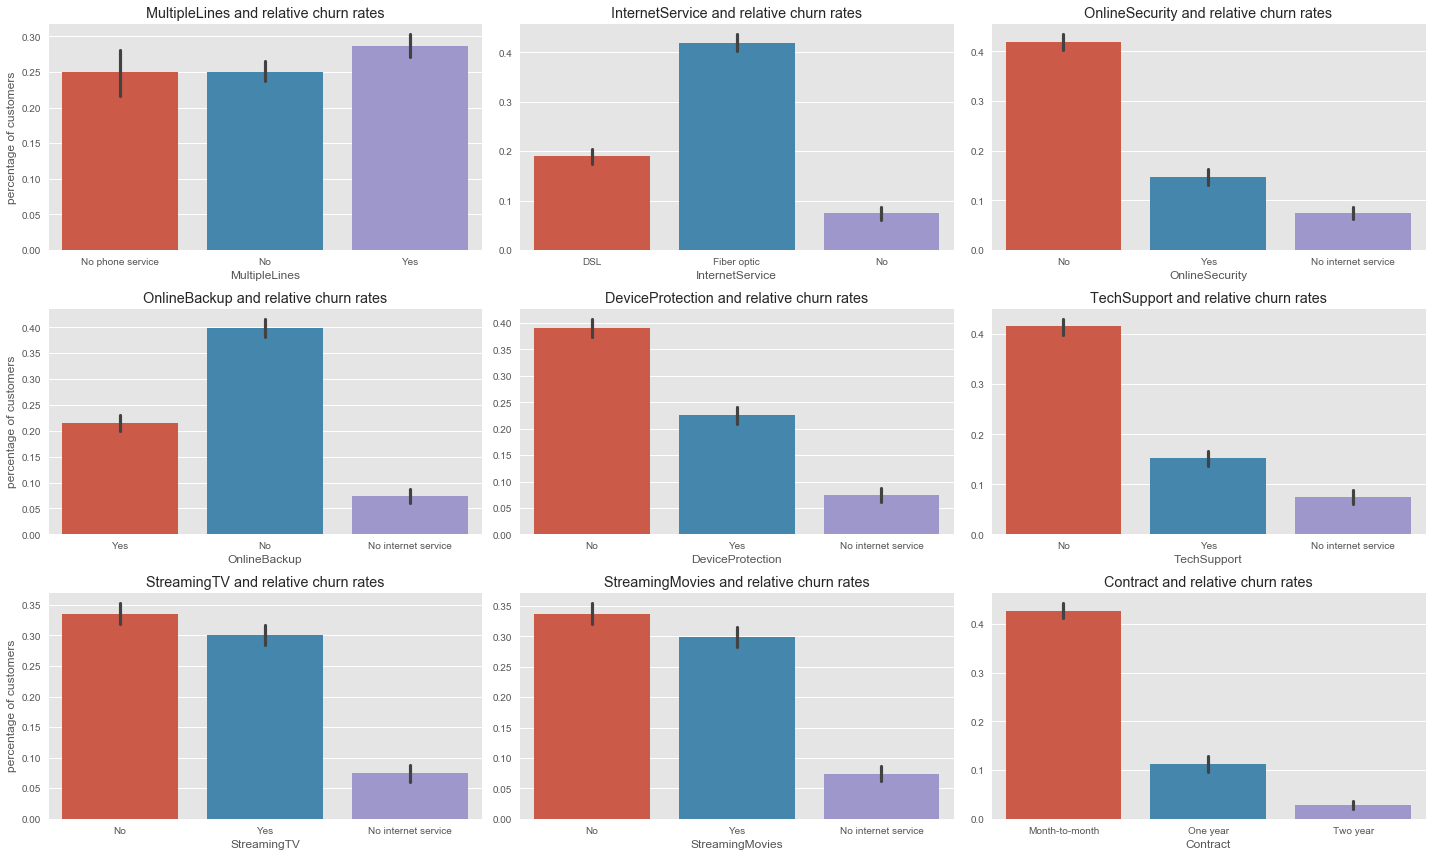

In [10]:
ter_fearures = [x for x in data.columns[data.nunique()==3] ]
fig, axis = plt.subplots(nrows = 3, ncols = 3, figsize = (20, 12))
for n,i in enumerate(ter_fearures):
    if n <3 :
        p = 0
    elif n <6:
        p = 1
        n-=3
    else :
        p = 2
        n-=6
    ax = sns.barplot(data[i],data['Churn_n'],ax=axis[p][n])
    if ((p == 0) & (n == 0))|((p == 1) & (n == 0)) |((p == 2) & (n == 0)) :
        ax.set_ylabel('percentage of customers')
    else:
        ax.set_ylabel('')
    ax.set_title("{} and relative churn rates".format(i))
    plt.tight_layout()

In [11]:
quater_fearures=[x for x in data.columns[data.nunique()==4] ]

Text(0.5,1,'PaymentMethod and relative churn rates')

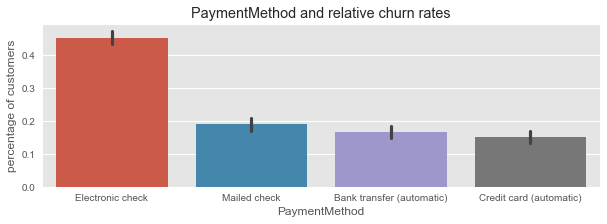

In [12]:
plt.figure(figsize=(10,3))
ax = sns.barplot(data[quater_fearures[0]],data['Churn_n'])
ax.set_ylabel('percentage of customers')
ax.set_title("{} and relative churn rates".format(quater_fearures[0]))

* 基本屬性
    * 性別(gender)不影響流失率。
    * 老年客戶(SeniorCitizen)有較高的流失率。
* 是否有同伴
    * 沒有夥伴(Partner)或沒有家屬(Dependents)的客戶有較高的流失率。
* 電話與服務
    * 電話服務(PhoneService)與流失率沒有直接相關。
    * 客戶的網路提供商(InternetService)為Fiber時有較高的流失率。
    * 客戶沒有網路安全服務(OnlineSecurity)、網路備份(OnlineBackup)、設備保護(DeviceProtection)、技術支援(TechSupport)時有較高的流失率。
* 合約與支付方式
    * 無紙化帳單(PaperlessBilling)的客戶有較高的流失率。
    * 使用電子支票支付(PaymentMethod)的客戶有較高的流失率。
    * 按月合約(Contract)的客戶有較高的流失率。

In [13]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'Churn_n'],
      dtype='object')

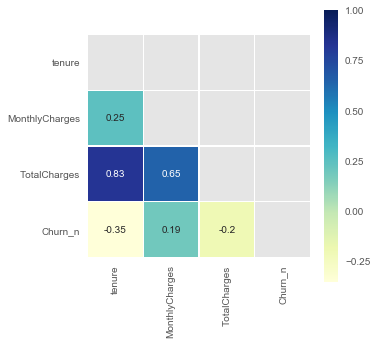

In [14]:
plt.figure(figsize=(5, 5))
corr = data.drop(columns = ['customerID']).corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, xticklabels=corr.columns,mask=mask, yticklabels=corr.columns, square=True,
                  linewidths=.2, cmap="YlGnBu",annot=True)

* 總收取費用(TotalCharges) 與往來時間(tenure)具高度線性相關是很合理的結果，這邊先保留兩者原始資訊。

# <a id='4'>4. 資料前處理</a>

In [15]:
data.drop(columns=['Churn_n','customerID'],inplace=True)

In [16]:
#目標變數
target_col = ["Churn"]
#類別變數
cat_cols   = data.nunique()[data.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#數值變數
num_cols   = [x for x in data.columns if x not in cat_cols + target_col ]
#二元變數
bin_cols   = data.nunique()[data.nunique() == 2].keys().tolist()
#多元變數
multi_cols = [i for i in cat_cols if i not in bin_cols]

#對二元變數編碼
le = LabelEncoder()
for i in bin_cols :
    data[i] = le.fit_transform(data[i])
    
#對多元變數編碼
data = pd.get_dummies(data = data,columns = multi_cols )

#標準化數值變數
std = StandardScaler()
data[num_cols] = std.fit_transform(data[num_cols])

In [17]:
data[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,5.945991e-17,1.000071,-1.318165,-0.951682,-0.137274,0.921455,1.613701
MonthlyCharges,7043.0,-8.291599e-17,1.000071,-1.545860,-0.972540,0.185733,0.833833,1.794352
TotalCharges,7043.0,5.088457e-17,1.000071,-1.005780,-0.829946,-0.390528,0.664803,2.825805


* 數值變數已標準化。

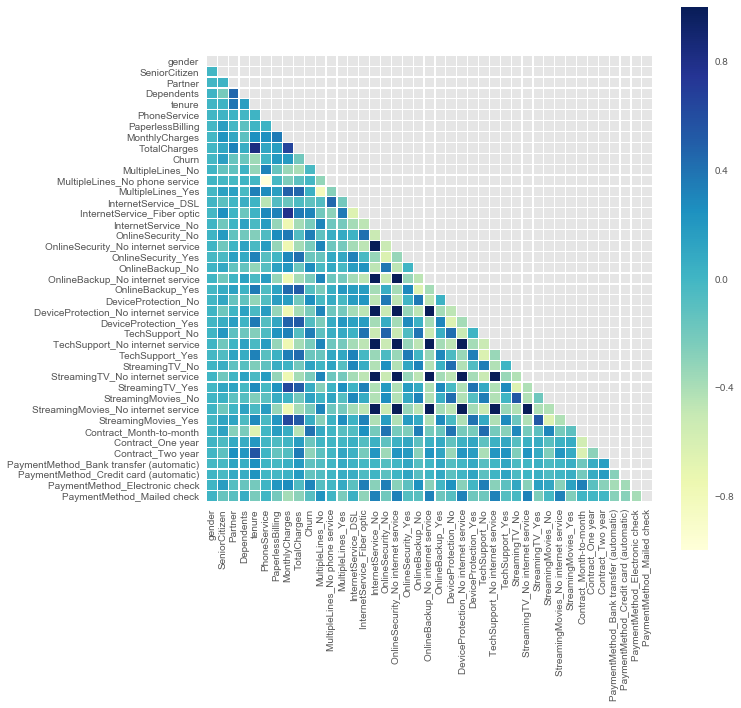

In [18]:
plt.figure(figsize=(10, 10))
corr = data.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, xticklabels=corr.columns,mask=mask, yticklabels=corr.columns, square=True,
                  linewidths=.2, cmap="YlGnBu")

* 將類別變數編碼後有許多重複的變數。例如: 'OnlineSecurity_No internet service' 和 'OnlineBackup_No internet service'。接著刪除重複變數。

In [19]:
for i in list(data.describe().loc['mean']):
    if list(data.describe().loc['mean']).count(i)!=1:
        k=i
data.describe().loc[:,data.describe().loc['mean'] ==k]

,InternetService_No,OnlineSecurity_No internet service,OnlineBackup_No internet service,DeviceProtection_No internet service,TechSupport_No internet service,StreamingTV_No internet service,StreamingMovies_No internet service
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.216669,0.216669,0.216669,0.216669,0.216669,0.216669,0.216669
std,0.412004,0.412004,0.412004,0.412004,0.412004,0.412004,0.412004
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
redundant = list(data.describe().loc[:,data.describe().loc['mean'] ==k].columns)[1:]
redundant.append('MultipleLines_No phone service') #'MultipleLines_No phone service'和'PhoneService'有相同資訊

In [21]:
#避免虛擬變數陷阱
redundant2 = [i for i in list(data.columns) if 'Yes' in i]

In [22]:
#去除多餘變數
data.drop(columns=redundant+redundant2,inplace=True) 

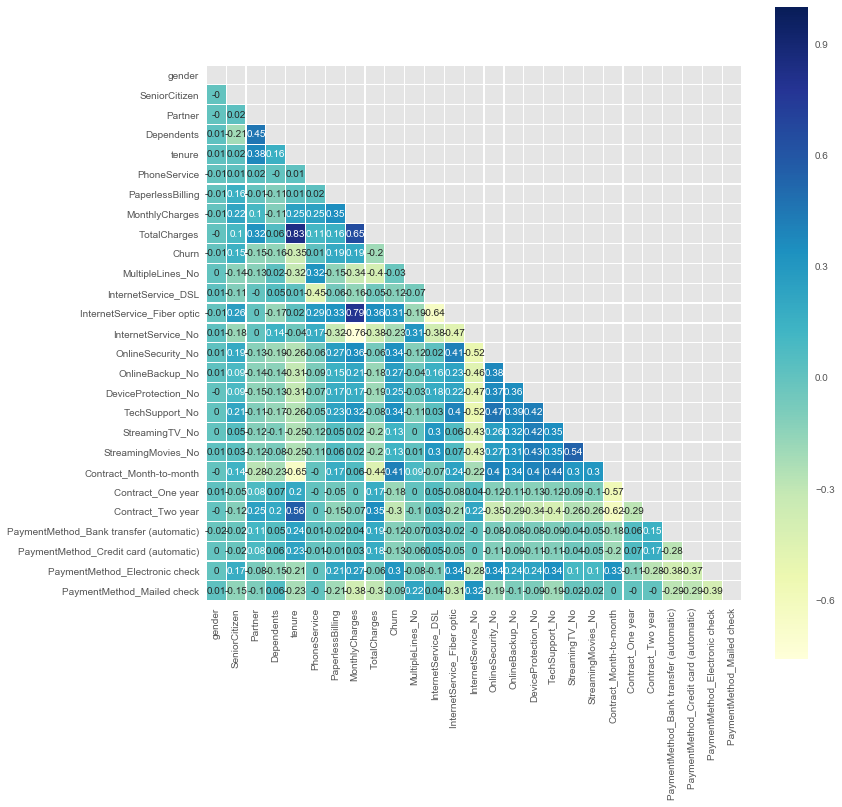

In [23]:
plt.figure(figsize=(12, 12))
corr = data.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(round(corr, 2), xticklabels=corr.columns,mask=mask, yticklabels=corr.columns, square=True,
                  linewidths=.2, cmap="YlGnBu",annot=True) #取小數點後兩位的corr

* 無重複變數

In [24]:
len(data.columns)

27

# <a id='5'>5. 建立模型</a>
除模型訓練外，亦視覺化呈現每個模型的
 - 混淆矩陣: 拆解模型在 TP、TN、FN、TN 的表現
 - ROC 曲線: 在給定模型的所有門檻值下，顯示相對的 TP 和 FP ，計算其曲線下方面積: AUC 可用以概述 ROC 曲線
 - 特徵重要性: 理解哪些特徵最能影響模型結果
 - Threshold Plot: 理解調整模型決策閾值如何影響評估結果

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer

churn = data['Churn']
features = data.drop('Churn', axis = 1)
cols = list(features.columns)

#splitting train and test data 
X_train, X_test, y_train, y_test = train_test_split(features, churn, test_size = .2 ,random_state = 0)

## <a id='5.1'>5.1. Logistic Regression (Baseline)</a>

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1041
           1       0.64      0.52      0.58       368

   micro avg       0.80      0.80      0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409

train
Accuracy   Score :  0.8077742279020235
Area under curve :  0.7308822910704099 

test
Accuracy   Score : 0.7984386089425124
Area under curve :  0.7098747546255691 



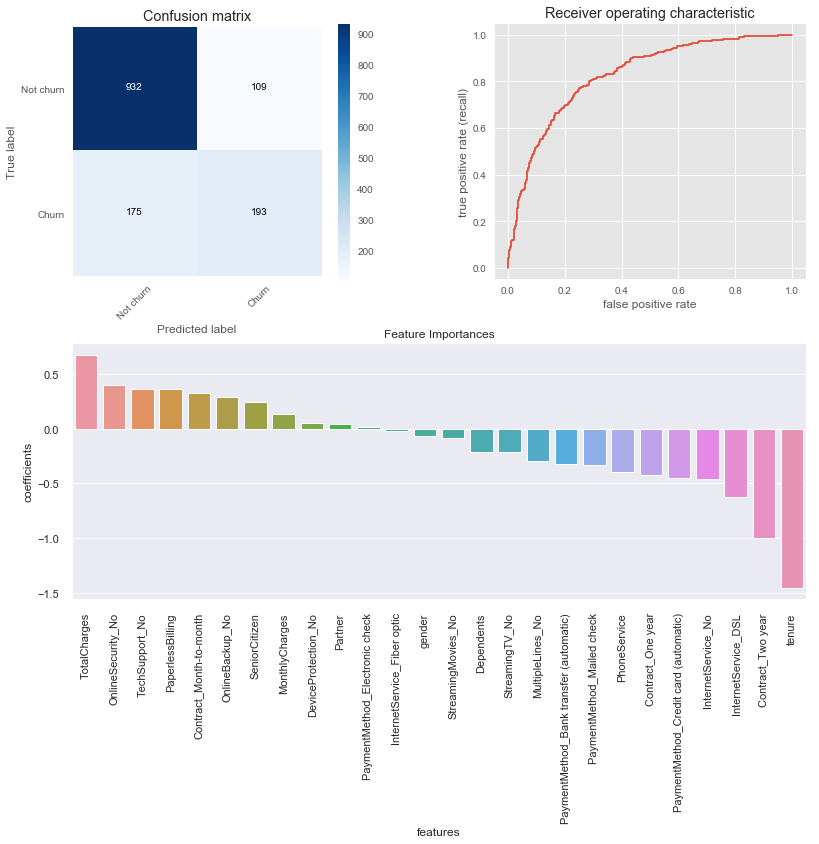

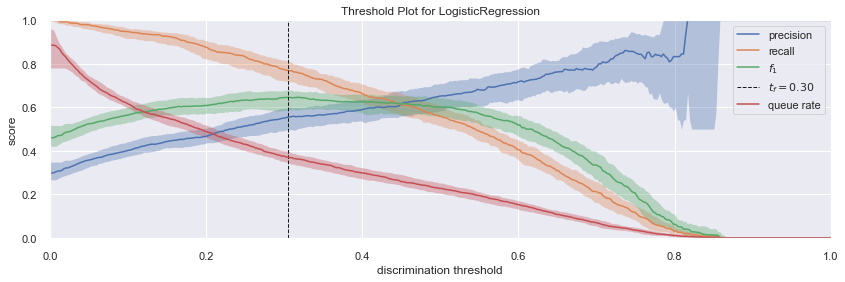

In [26]:
logit  = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
logit_result = tl.telecom_churn_prediction(logit,'Logistic Regression (Baseline)',X_train, X_test, y_train, y_test,
                         cols,cf = "coefficients",plot = True,threshold=True)

* 過度擬合: Logistic Regression (Baseline) 無明顯過擬合問題。
* 特徵分析: 導致高流失率的前五特徵有
1.較短往來時間 2.非兩年合約 3.不使用DSL網路服務 4.總收取費用較高 5.不使用信用卡支付。

## <a id='5.2'>5.2. Synthetic Minority Oversampling Technique (SMOTE)</a>
對於前述提到不平衡目標變數問題，採 SMOTE 方式(利用已有樣本生成更多樣本)處理，具體步驟為
* 隨機選擇少數類樣本的一點
* 以歐氏距離計算它到少數類樣本集中所有樣本的距離，得到 k 個近鄰 
* 對每個最近鄰到目標樣本間乘以 0~1 之間的一個比例，增加到樣本內

In [27]:
from imblearn.over_sampling import SMOTE

#Split train and test data
X_train, X_test, y_train, y_test = train_test_split(features,churn,test_size = .2 ,random_state = 0)

#oversampling minority class using smote
os = SMOTE(random_state = 0)
X_os_smote,y_os_smote = os.fit_sample(X_train,y_train)

X_os_smote = pd.DataFrame(data = X_os_smote,columns=cols)
y_os_smote = pd.DataFrame(data = y_os_smote,columns=target_col)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.90      0.73      0.81      1041
           1       0.50      0.78      0.61       368

   micro avg       0.74      0.74      0.74      1409
   macro avg       0.70      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409

train
Accuracy   Score :  0.7838132107428019
Area under curve :  0.7838132107428019 

test
Accuracy   Score : 0.7423704755145494
Area under curve :  0.7553773545503905 



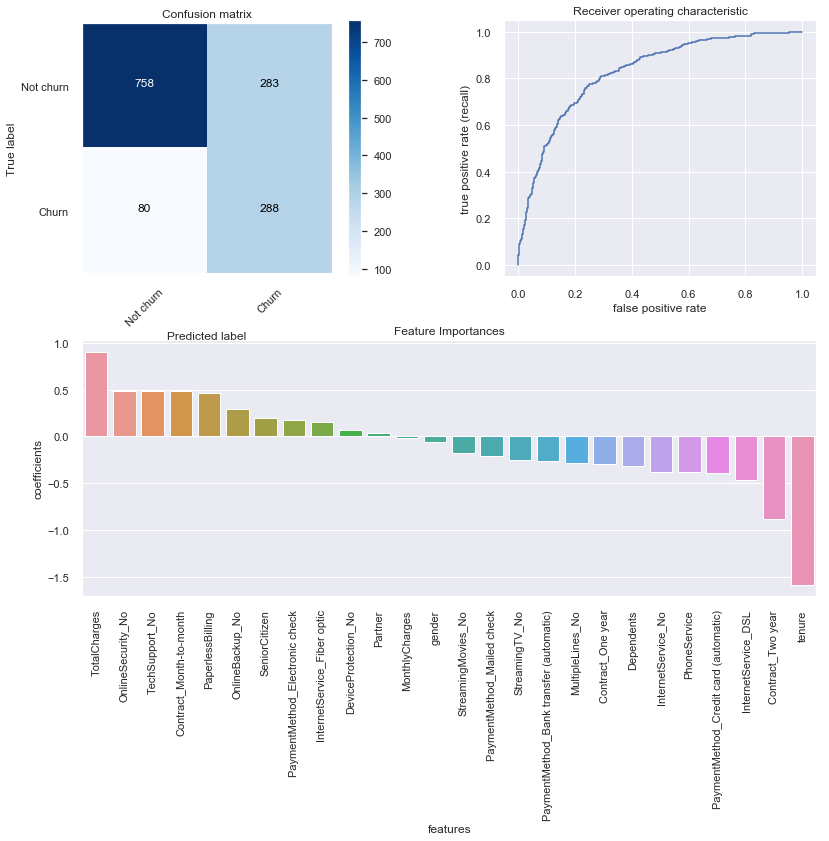

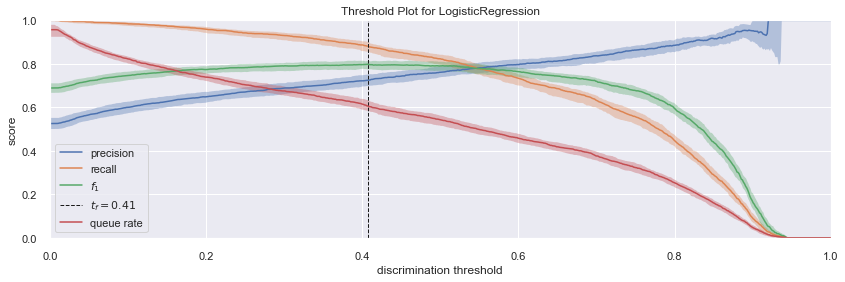

In [28]:
logit_smote = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

logit_smote_result = tl.telecom_churn_prediction(logit_smote,'Logistic Regression(Smote)',X_os_smote,X_test,y_os_smote,y_test,
                         cols,"coefficients",plot = True,threshold=True)

* 經過 SMOTE 後的 Logistic Regression AUC 從 0.709 上升至 0.755 ，明顯增加模型泛化能力。
* 特徵分析: 特徵係數排名大致與未使用 SMOTE 時相同，僅係數值發生變化

## <a id='5.3'>5.3. Recursive Feature Elimination (RFE)</a>
當只考慮重要特徵時模型使否能有相似的表現呢?遞歸特徵消除（RFE）根據模型丟棄最不重要的特徵，然後使用丟棄之外的所有特徵建立新模型，直到只剩下預先指定的特徵數量為止。

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.91      0.72      0.81      1041
           1       0.50      0.79      0.62       368

   micro avg       0.74      0.74      0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409

train
Accuracy   Score :  0.7783692233244617
Area under curve :  0.7783692233244616 

test
Accuracy   Score : 0.7423704755145494
Area under curve :  0.7588909075721505 



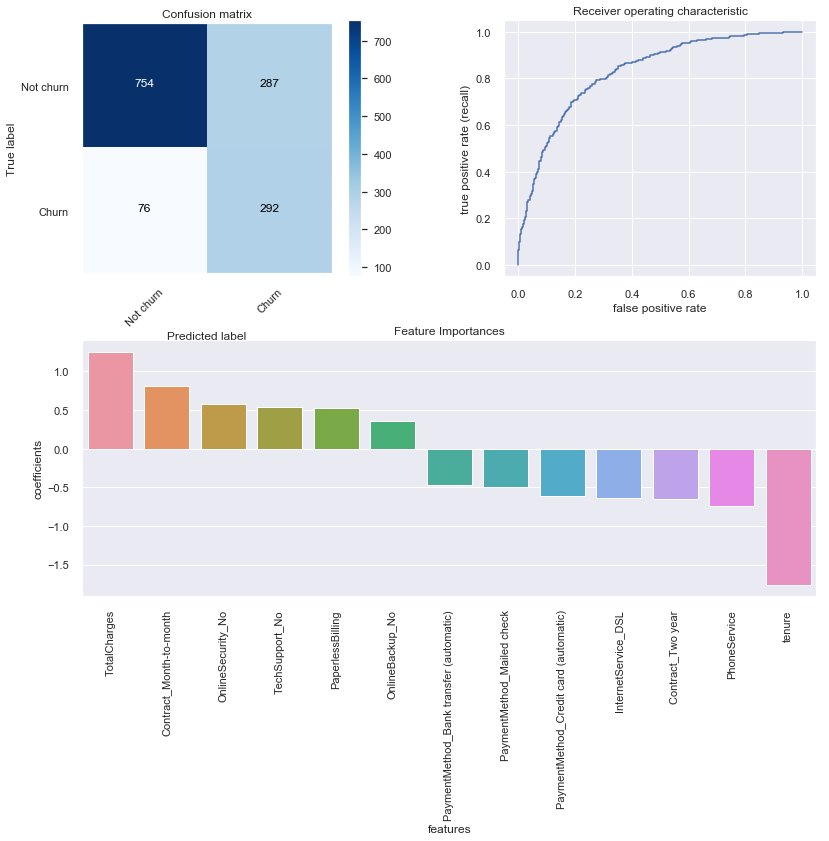

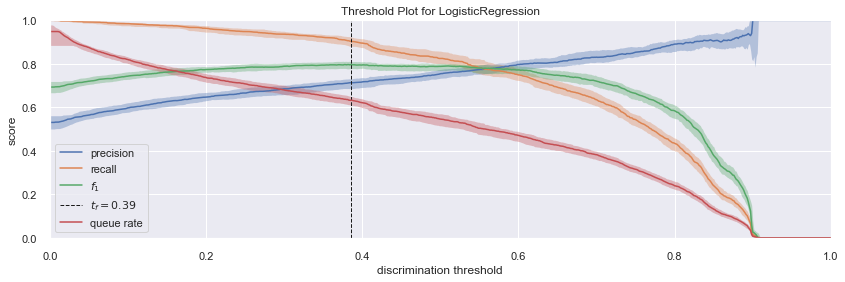

,columns,ranking,rfe_support
25,PaymentMethod_Mailed check,1,True
23,PaymentMethod_Credit card (automatic),1,True
22,PaymentMethod_Bank transfer (automatic),1,True
4,tenure,1,True
5,PhoneService,1,True
6,PaperlessBilling,1,True
21,Contract_Two year,1,True
8,TotalCharges,1,True
10,InternetService_DSL,1,True
19,Contract_Month-to-month,1,True


In [29]:
from sklearn.feature_selection import RFE

logit_rfe = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

rfe = RFE(logit,n_features_to_select=13)
rfe = rfe.fit(X_os_smote,y_os_smote.values.ravel())

#identified columns Recursive Feature Elimination
idc_rfe = pd.DataFrame({"rfe_support" :rfe.support_,
                       "columns" :  list(features.columns),
                       "ranking" : rfe.ranking_,
                      })
cols_rfe = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist()

#separating train and test data
X_train_rf = X_os_smote[cols_rfe]
y_train_rf = y_os_smote
X_test_rf  = X_test[cols_rfe]
y_test_rf  = y_test

#applying model
logit_rfe_result= tl.telecom_churn_prediction(logit_rfe,'Logistic Regression(RFE)',X_train_rf,X_test_rf,y_train_rf,y_test_rf,
                         cols_rfe,"coefficients",plot = True,threshold=True)
idc_rfe.sort_values(by='ranking')

* 當僅使用前 13 個重要特徵預測時，Logistic Regression 的 AUC 為 0.758 ，不比使用所有特徵的預測結果還差。
* 特徵分析: 導致高流失率的前五特徵順序改為
1.較短往來時間 2.總收取費用較低 3.使用按月合約 4.未使用電話服務 5.非兩年合約。

## <a id='5.4'>5.4. K-Neighbors Classifier</a>

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

 Classification report : 
               precision    recall  f1-score   support

           0       0.88      0.70      0.78      1041
           1       0.46      0.73      0.57       368

   micro avg       0.71      0.71      0.71      1409
   macro avg       0.67      0.72      0.68      1409
weighted avg       0.77      0.71      0.73      1409

train
Accuracy   Score :  0.8345027824824582
Area under curve :  0.8345027824824583 

test
Accuracy   Score : 0.7097232079489
Area under curve :  0.7174722257027106 



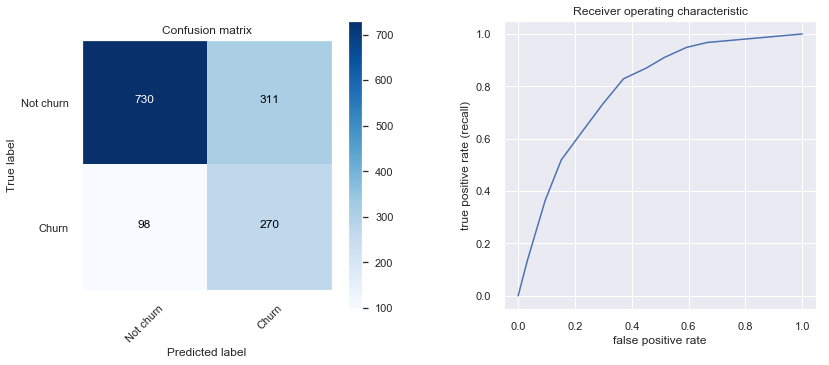

In [30]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2)

knn_result = tl.telecom_churn_prediction(knn,'KNeighbors',X_os_smote,X_test,y_os_smote,y_test,cols,None,plot = True)

## <a id='5.5'>5.5. Decision Tree Classifier</a>

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

 Classification report : 
               precision    recall  f1-score   support

           0       0.89      0.75      0.81      1041
           1       0.51      0.74      0.60       368

   micro avg       0.75      0.75      0.75      1409
   macro avg       0.70      0.74      0.71      1409
weighted avg       0.79      0.75      0.76      1409

train
Accuracy   Score :  0.8040164529397532
Area under curve :  0.8040164529397532 

test
Accuracy   Score : 0.7466288147622427
Area under curve :  0.7442049868437539 



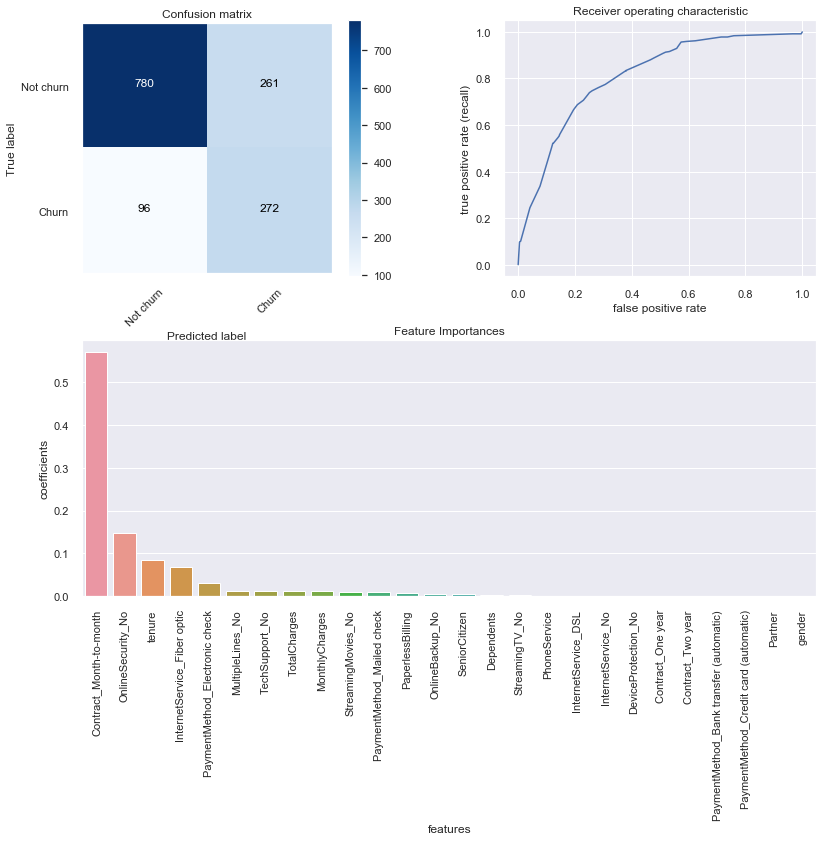

In [31]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=6,random_state=0)
dt_result = tl.telecom_churn_prediction(dt,'Decision Tree',X_os_smote,X_test,y_os_smote,y_test,
                         cols,"features",plot=True)

* 過度擬合: Decision Tree 有過擬合問題。
* 特徵分析: 影響流失率的前五特徵有
1.按月合約 2.是否有網路安全服務 3.往來時間 4.網路提供商(InternetService)是否為Fiber 5.是否使用電子支票支付。

## <a id='5.6'>5.6. Random Forest Classifier</a>

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.90      0.75      0.82      1041
           1       0.51      0.76      0.61       368

   micro avg       0.75      0.75      0.75      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.80      0.75      0.76      1409

train
Accuracy   Score :  0.805710137914348
Area under curve :  0.805710137914348 

test
Accuracy   Score : 0.7501774308019872
Area under curve :  0.7536336298709435 



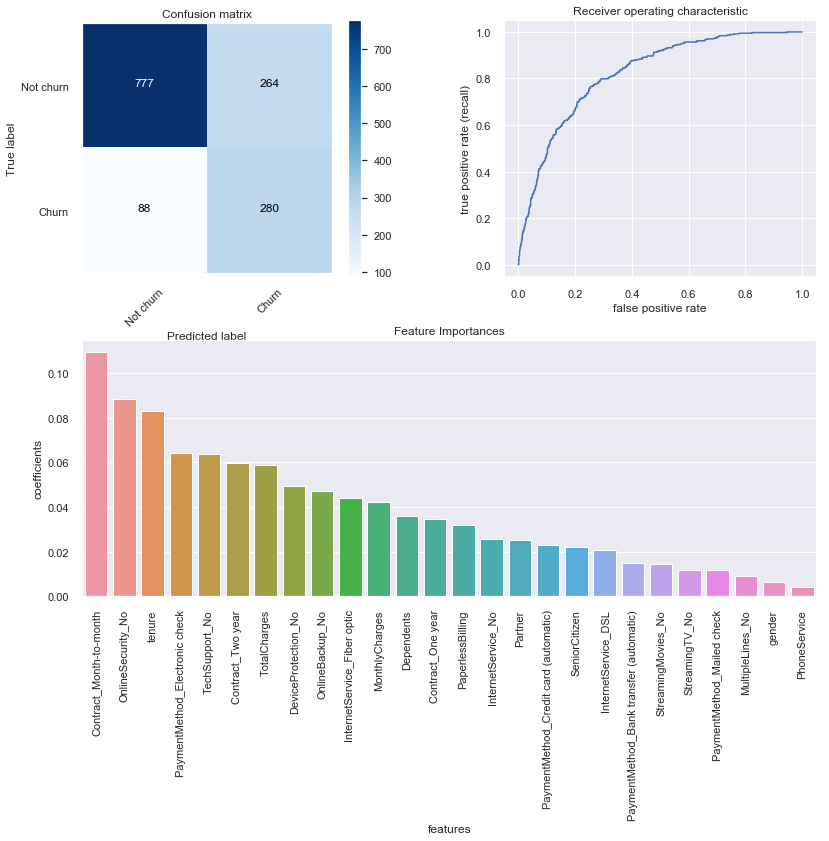

In [32]:
from sklearn.ensemble import RandomForestClassifier
rf   = RandomForestClassifier(n_estimators=200,max_features=1,max_depth=6,random_state=0)

rf_result = tl.telecom_churn_prediction(rf,'Random Forest',X_os_smote,X_test,y_os_smote,y_test,
                         cols,"features",plot=True)

* 過度擬合: Random Forest 有過擬合問題。
* 特徵分析: 影響流失率的前五特徵中與決策樹不同的有
4.是否使用電子支票支付 5.是否有技術支援。

## <a id='5.7'>5.7. Gaussian Naive Bayes</a>

GaussianNB(priors=None, var_smoothing=1e-09)

 Classification report : 
               precision    recall  f1-score   support

           0       0.90      0.68      0.78      1041
           1       0.47      0.79      0.59       368

   micro avg       0.71      0.71      0.71      1409
   macro avg       0.68      0.74      0.68      1409
weighted avg       0.79      0.71      0.73      1409

train
Accuracy   Score :  0.7626421485603677
Area under curve :  0.7626421485603678 

test
Accuracy   Score : 0.7097232079489
Area under curve :  0.7350399908115107 



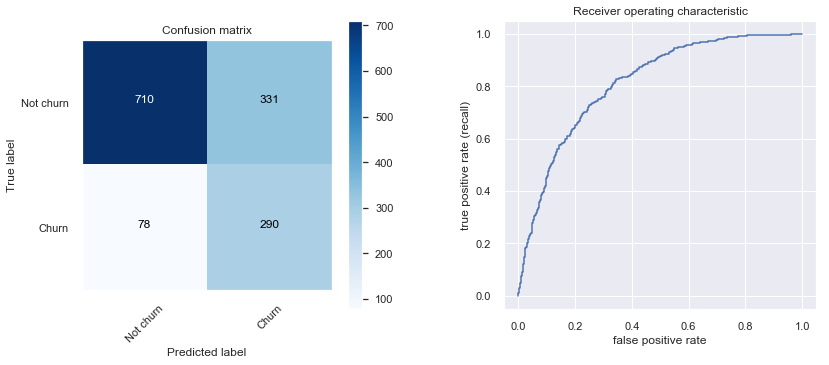

In [33]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB(priors=None)

gnb_result = tl.telecom_churn_prediction(gnb,'GaussianNB',X_os_smote,X_test,y_os_smote,y_test,cols,plot = True)

## <a id='5.8'>5.8. Support Vector Machine</a>

SVM(linear)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.0, kernel='linear',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.90      0.69      0.78      1041
           1       0.48      0.79      0.59       368

   micro avg       0.72      0.72      0.72      1409
   macro avg       0.69      0.74      0.69      1409
weighted avg       0.79      0.72      0.73      1409

train
Accuracy   Score :  0.7697798209533027
Area under curve :  0.7697798209533027 

test
Accuracy   Score : 0.7182398864442867
Area under curve :  0.7408036795723176 



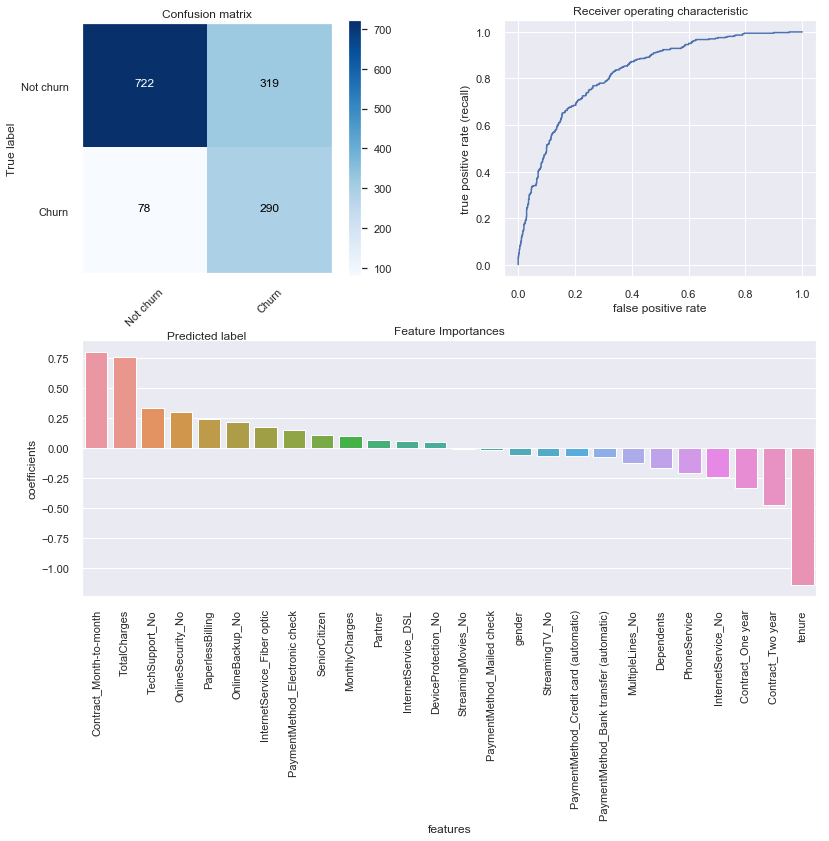

In [34]:
from sklearn.svm import SVC

#Support vector classifier
#using linear hyper plane
svc_lin  = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
               decision_function_shape='ovr', degree=3, gamma=1.0, kernel='linear',
               max_iter=-1, probability=True, random_state=0, shrinking=True,
               tol=0.001, verbose=False)
svc_lin_result = tl.telecom_churn_prediction(svc_lin,'SVM(linear)',X_os_smote,X_test,y_os_smote,y_test,
                         cols,"coefficients",plot = True)

* 過度擬合: Support vector classifier(linear) 無明顯過擬合問題。
* 特徵分析: 導致高流失率的前五特徵有
1.較短往來時間 2.按月支付 3.總收取費用較高 4.非兩年合約 5.無技術支援。

SVM(rbf)

SVC(C=0.2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.90      0.73      0.81      1041
           1       0.50      0.76      0.60       368

   micro avg       0.74      0.74      0.74      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.79      0.74      0.75      1409

train
Accuracy   Score :  0.7891362206629567
Area under curve :  0.7891362206629567 

test
Accuracy   Score : 0.7388218594748048
Area under curve :  0.745948711523201 



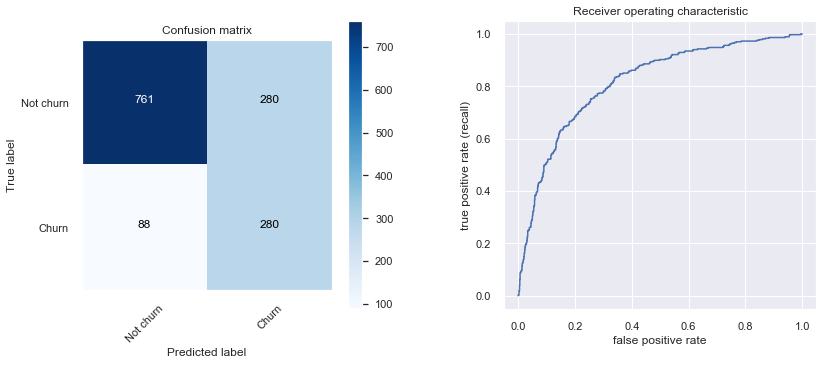

In [35]:
svc_rbf  = SVC(C=0.2, cache_size=200, class_weight=None, coef0=0.0,
               decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
               max_iter=-1, probability=True, random_state=None, shrinking=True,
               tol=0.001, verbose=False)
svc_rbf_result = tl.telecom_churn_prediction(svc_rbf,'SVM(rbf)',X_os_smote,X_test,y_os_smote,y_test,
                         cols,plot = True)

* 過度擬合: Support vector classifier(rbf) 有過擬合問題。

## <a id='5.9'>5.9. LGBM Classifier</a>

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=2,
        min_child_samples=5, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=1000, n_jobs=-1, num_leaves=500, objective='binary',
        random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

 Classification report : 
               precision    recall  f1-score   support

           0       0.85      0.86      0.85      1041
           1       0.59      0.55      0.57       368

   micro avg       0.78      0.78      0.78      1409
   macro avg       0.72      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409

train
Accuracy   Score :  0.8815630292765546
Area under curve :  0.8815630292765546 

test
Accuracy   Score : 0.7821149751596878
Area under curve :  0.7084899553105292 



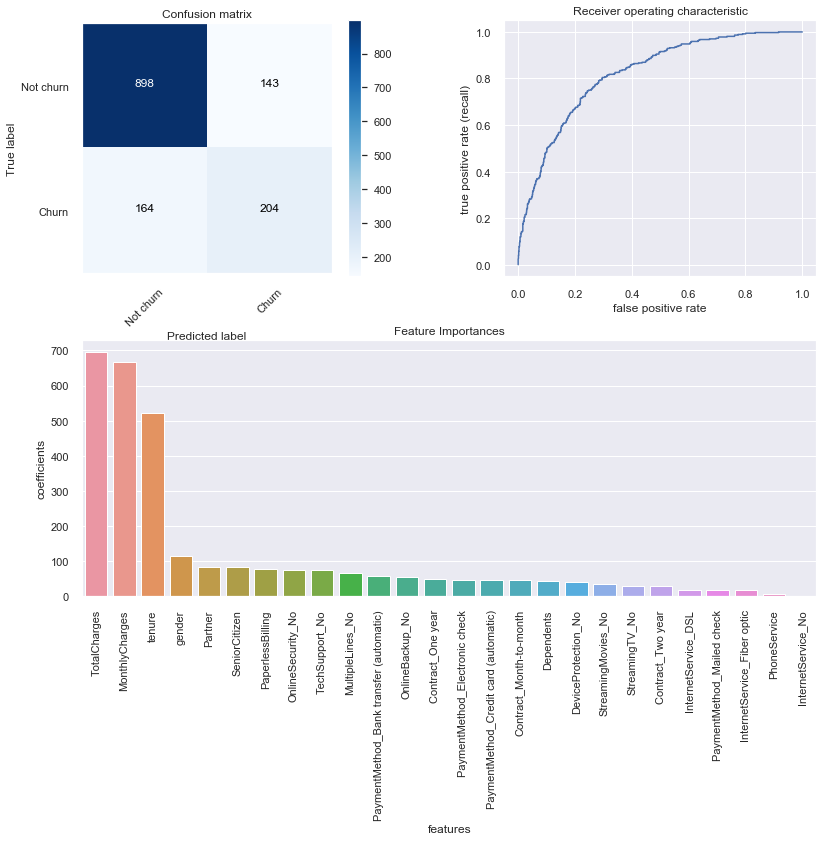

In [36]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                        learning_rate=0.1, max_depth=2, min_child_samples=5,
                        min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
                        n_jobs=-1, num_leaves=500, objective='binary', random_state=0,
                        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=.8,
                        subsample_for_bin=200000, subsample_freq=0)

lgbm_result = tl.telecom_churn_prediction(lgbm,'LGBM Classifier',X_os_smote,X_test,y_os_smote,y_test,
                         cols,"features",plot=True)

* 過度擬合: LGBM Classifier 有過擬合問題。
* 特徵分析: 影響流失率的前五特徵有 1.總收取費用 2.每月收取費用 3.往來時間 4.性別 5.是否有伙伴。

## <a id='5.10'>5.10. XGBoost Classifier</a>

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

 Classification report : 
               precision    recall  f1-score   support

           0       0.84      0.85      0.85      1041
           1       0.57      0.56      0.56       368

   micro avg       0.77      0.77      0.77      1409
   macro avg       0.71      0.70      0.70      1409
weighted avg       0.77      0.77      0.77      1409

train
Accuracy   Score :  0.9814904427776434
Area under curve :  0.9814904427776433 

test
Accuracy   Score : 0.772888573456352
Area under curve :  0.7040027356638684 



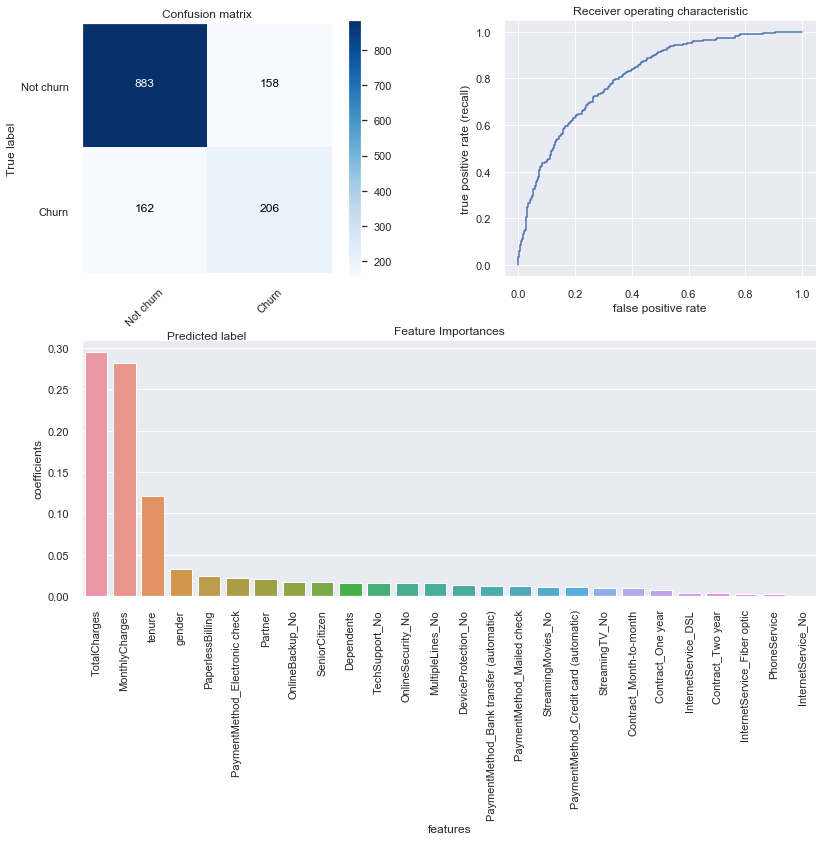

In [37]:
from xgboost import XGBClassifier

xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
                    max_depth = 5, min_child_weight=1, missing=None, n_estimators=1000,
                    n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)


xgb_result  = tl.telecom_churn_prediction(xgb,'XGBoost Classifier',X_os_smote,X_test,y_os_smote,y_test,
                         cols,"features",plot=True)

* 過度擬合: XGBoost Classifier 有過擬合問題。
* 特徵分析: 影響流失率的前五特徵有 1.總收取費用 2.每月收取費用 3.往來時間 4.性別 5.使否使用無紙帳單。

## <a id='5.11'>5.11. MLP Classifier</a>

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.84      0.83      0.83      1041
           1       0.52      0.54      0.53       368

   micro avg       0.75      0.75      0.75      1409
   macro avg       0.68      0.68      0.68      1409
weighted avg       0.75      0.75      0.75      1409

train
Accuracy   Score :  0.9164045487539317
Area under curve :  0.9164045487539317 

test
Accuracy   Score : 0.7508871540099361
Area under curve :  0.6829644885770371 



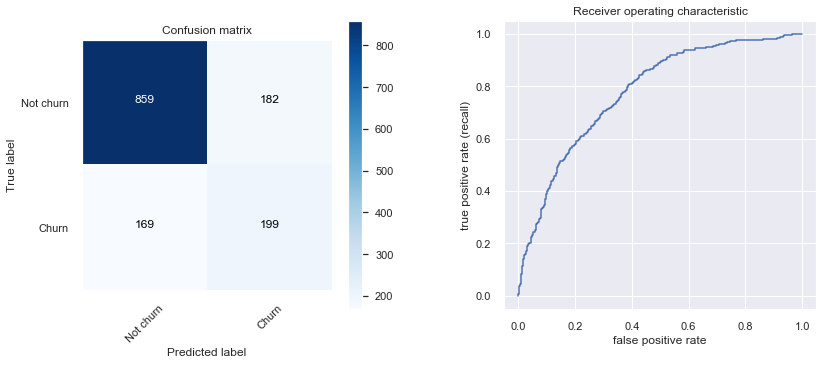

In [38]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=1000)
mlp_result  = tl.telecom_churn_prediction(mlp,'MLP Classifier',X_os_smote,X_test,y_os_smote,y_test,
                         cols,plot=True)

* 過度擬合: MLP Classifier 有過擬合問題。

# <a id='6'>6. 模型評估</a>

## <a id='6.1'>6.1. 模型評估表</a>

In [39]:
pd.concat([logit_result,logit_smote_result,logit_rfe_result,
knn_result,dt_result,rf_result,
gnb_result,svc_lin_result,svc_rbf_result,
lgbm_result,xgb_result,mlp_result],axis = 0,ignore_index=True)

,Accuracy_score,Area_under_curve(test),Area_under_curve(train),Model,Precision,Recall_score,f1_score,pred_time,train_time
0,0.798439,0.709875,0.730882,Logistic Regression (Baseline),0.639073,0.524457,0.576119,0.0060,0.0339
1,0.742370,0.755377,0.783813,Logistic Regression(Smote),0.504378,0.782609,0.613419,0.0010,0.0239
2,0.742370,0.758891,0.778369,Logistic Regression(RFE),0.504318,0.793478,0.616684,0.0010,0.0120
3,0.709723,0.717472,0.834503,KNeighbors,0.464716,0.733696,0.569020,0.1995,0.0140
4,0.746629,0.744205,0.804016,Decision Tree,0.510319,0.739130,0.603774,0.0000,0.0230
5,0.750177,0.753634,0.805710,Random Forest,0.514706,0.760870,0.614035,0.0399,0.4071
6,0.709723,0.735040,0.762642,GaussianNB,0.466989,0.788043,0.586451,0.0020,0.0060
7,0.718240,0.740804,0.769780,SVM(linear),0.476190,0.788043,0.593654,0.1287,10.2639
8,0.738822,0.745949,0.789136,SVM(rbf),0.500000,0.760870,0.603448,0.2110,10.9797
9,0.782115,0.708490,0.881563,LGBM Classifier,0.587896,0.554348,0.570629,0.0120,0.4812


## <a id='6.2'>6.2. 學習曲線評估</a>

LogisticRegression test mean scores = 0.6323850540378179 
KNeighborsClassifier test mean scores = 0.5849882110587034 
DecisionTreeClassifier test mean scores = 0.5904718157842662 
RandomForestClassifier test mean scores = 0.5890439721156151 
GaussianNB test mean scores = 0.5337208018872565 
SVC test mean scores = 0.6211867447209812 
SVC test mean scores = 0.6115904807614511 
LGBMClassifier test mean scores = 0.6148885328118296 
XGBClassifier test mean scores = 0.578285365742475 
MLPClassifier test mean scores = 0.5567812577373741 


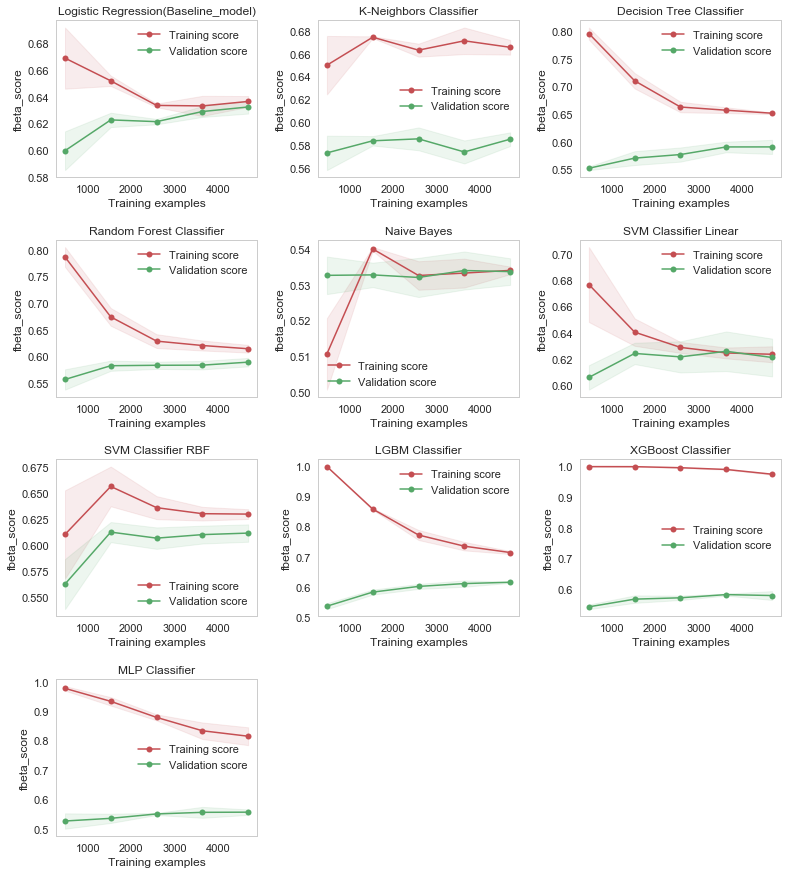

In [40]:
plt.style.use('seaborn-whitegrid')
lst    = [logit,knn,dt,rf,gnb,svc_lin,svc_rbf,lgbm,xgb,mlp]

length = len(lst)

mods   = ['Logistic Regression(Baseline_model)',
          'K-Neighbors Classifier','Decision Tree Classifier','Random Forest Classifier',"Naive Bayes",
          'SVM Classifier Linear','SVM Classifier RBF', 'LGBM Classifier',
          'XGBoost Classifier','MLP Classifier']

fig = plt.figure(figsize=(13,15))
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    plt.subplot(4,3,j+1)
    tl.plot_learning_curve(i,k,features,churn)
    plt.subplots_adjust(wspace = .3,hspace = .4)

## <a id='6.3'>6.3. 混淆矩陣評估</a>

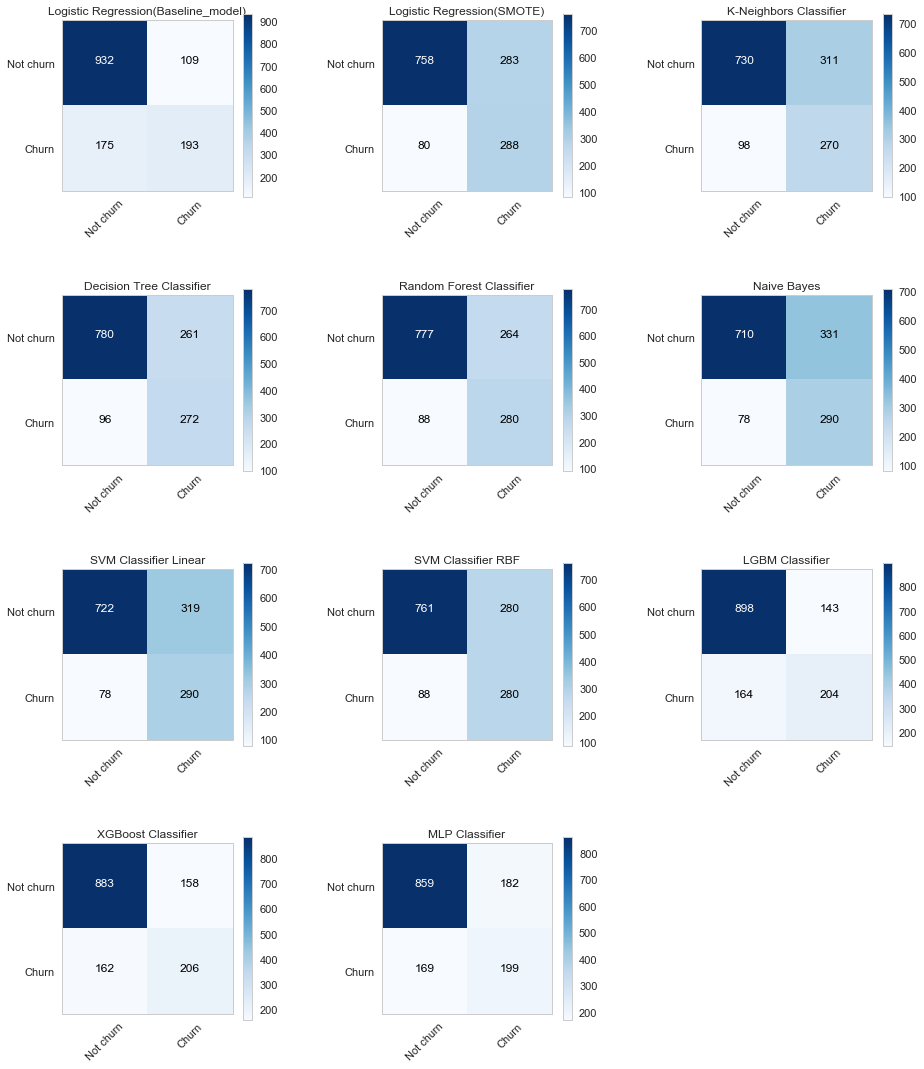

In [41]:
lst    = [logit,logit_smote,knn,dt,rf,gnb,svc_lin,svc_rbf,lgbm,xgb,mlp]

length = len(lst)

mods   = ['Logistic Regression(Baseline_model)','Logistic Regression(SMOTE)',
          'K-Neighbors Classifier','Decision Tree Classifier','Random Forest Classifier',"Naive Bayes",
          'SVM Classifier Linear','SVM Classifier RBF', 'LGBM Classifier',
          'XGBoost Classifier','MLP Classifier']

fig = plt.figure(figsize=(13,15))
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    plt.subplot(4,3,j+1)
    plt.grid(b=None) 
    predictions = i.predict(X_test)
    conf_matrix = confusion_matrix(y_test,predictions)
    tl.plot_confusion_matrix(conf_matrix,["Not churn","Churn"],title=k,label=False)
    plt.subplots_adjust(wspace = .5,hspace = .5)

## <a id='6.4'>6.4. ROC 曲線評估</a>

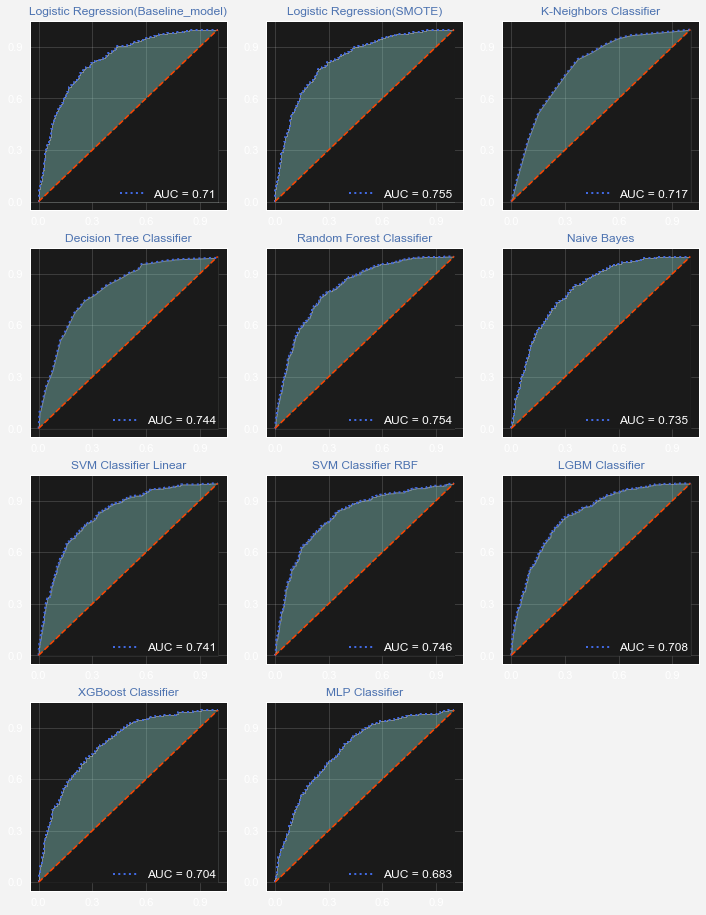

In [42]:
plt.style.use("dark_background")
fig = plt.figure(figsize=(12,16))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    qx = plt.subplot(4,3,j+1)
    probabilities = i.predict_proba(X_test)
    predictions   = i.predict(X_test)
    fpr,tpr,thresholds = roc_curve(y_test,probabilities[:,1])
    plt.plot(fpr,tpr,linestyle = "dotted",
             color = "royalblue",linewidth = 2,
             label = "AUC = " + str(np.around(roc_auc_score(y_test,predictions),3)))
    plt.plot([0,1],[0,1],linestyle = "dashed",
             color = "orangered",linewidth = 1.5)
    plt.fill_between(fpr,tpr,alpha = .4)
    plt.fill_between([0,1],[0,1],color = "k")
    plt.legend(loc = "lower right",
               prop = {"size" : 12})
    qx.set_facecolor("k")
    plt.grid(True,alpha = .15)
    plt.title(k,color = "b")
    plt.xticks(np.arange(0,1,.3))
    plt.yticks(np.arange(0,1,.3))

* 僅使用重要特徵的 Logistic Regression(RFE) 在 AUC(0.758)、Recall(0.793)、f1_score(0.616)、pred_time 上表現最佳，可說是整體而言最佳的模型。
* GaussianNB 在訓練時間上表現最佳，訓練時間最久的是 MLP Classifier。
* 預測時間最久的是 SVM(rbf)。
* 除了 Logistic Regression、Naive Bayes、SVM Classifier Linear 以外其餘模型皆有過擬合問題。
* 當實際為流失，預測其為流失(recall)表現最佳的模型是 Logistic Regression、Naive Bayes 及 SVM Classifier Linear。
* 當實際為未流失，預設其為未流失表現最佳的模型是 LGBM Classifier。

# <a id='7'>7. 結論</a>

* 整體而言 Logistic Regression 在此資料集的的預測表現優於其他更複雜的模型。
* 透過生成特徵(SMOTE)方法能夠改善不平衡資料的泛化能力。
* 較複雜的模型能在訓練集中表現良好，卻都有過擬合的問題，例如 LGBM Classifier、 XGBoost Classifier、MLP Classifier。
* 往來時間、總收取費用、合約類型、繳費方式最能影響模型的預測結果。 

# <a id='8'>8. 參考資料</a>

- [SMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html)


- [kaggle_kernal](https://www.kaggle.com/pavanraj159/telecom-customer-churn-prediction)


- [tableau](https://public.tableau.com/profile/sandeep7769#!/vizhome/CustomerChurnAnalysis_4/TelecomCustomerChurnDataExploration)


- [scikit-learn](https://scikit-learn.org/stable/index.html)


- [threshold](https://www.scikit-yb.org/en/latest/api/classifier/threshold.html)